In [44]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Load text datasets from Google Drive
path = "/content/drive/MyDrive/CSC8111_Coursework/" # Change path to run program

train = pd.read_csv(path + "Tweets_train.csv", encoding="ISO-8859-1")
test = pd.read_csv(path + "Tweets_test.csv", encoding="ISO-8859-1")
dev = pd.read_csv(path + "Tweets_dev.csv", encoding="ISO-8859-1")

train = train.to_numpy()
test = test.to_numpy()
dev = dev.to_numpy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
combined_array = train
combined_array = np.r_[combined_array, test]
combined_array = np.r_[combined_array, dev]

In [46]:
def create_arrays(array):
  array_x = []
  array_y = []

  count_pos = 0
  count_neu = 0
  count_neg = 0

  for value in array:
    array_x.append(value[1])
    array_y.append(value[2])
    if value[2] == "positive": count_pos += 1
    elif value[2] == "neutral": count_neu += 1
    elif value[2] == "negative": count_neg += 1

  print("Positive count: %d" % count_pos)
  print("Neutral count: %d" % count_neu)
  print("Negative count: %d" % count_neg)

  array_x = np.array(array_x, dtype=object)
  array_y = np.array(array_y, dtype=object)

  return array_x, array_y

In [47]:
from nltk.sem.logic import Tokens
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import string

def clean_array(array):
  clean_array = []
  for tweet in array:
    # Split tweet into words
    tokens = tweet.split()
    # Remove @ tags
    tokens = [word for word in tokens if word[0] != "@"]
    # Remove punctuation
    remove_table = str.maketrans("", "", string.punctuation)
    tokens = [word.translate(remove_table) for word in tokens]
    # Remove non-alphabetic words
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    # Remove one character words
    tokens = [word for word in tokens if len(word) > 1]
    # Convert all characters to lower case
    tokens = [word.lower() for word in tokens]
    # Join words back together into single string
    clean_array.append(" ".join(tokens))
  clean_array = np.array(clean_array, dtype=object)
  
  return clean_array

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
combined_array_x, combined_array_y = create_arrays(combined_array)
combined_array_x = clean_array(combined_array_x)

Positive count: 2363
Neutral count: 3099
Negative count: 9178


In [49]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, split=' ')
tokenizer.fit_on_texts(combined_array_x)
tokenized_x = tokenizer.texts_to_sequences(combined_array_x)
tokenized_x = pad_sequences(tokenized_x)

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(combined_array_y)

In [51]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(tokenized_x, encoded_y, test_size = 0.3)
test_x, valid_x, test_y, valid_y = train_test_split(test_x, test_y, test_size = 1/3)

In [52]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=len(train_x[0])))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 22, 128)           640000    
                                                                 
 lstm_3 (LSTM)               (None, 196)               254800    
                                                                 
 dense_3 (Dense)             (None, 3)                 591       
                                                                 
Total params: 895,391
Trainable params: 895,391
Non-trainable params: 0
_________________________________________________________________


In [53]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

model.compile(optimizer=Adam(0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Stops training if 5 consecutive epochs don't improve on best previous accuracy
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

model_output = model.fit(x=train_x, y=train_y, epochs=50, validation_data=(valid_x, valid_y), callbacks=[es])
model.evaluate(test_x, test_y)

Epoch 1/50
321/321 [==============================] - 48s 139ms/step - loss: 0.8825 - accuracy: 0.6259 - val_loss: 0.7741 - val_accuracy: 0.6660
Epoch 2/50
321/321 [==============================] - 44s 137ms/step - loss: 0.7336 - accuracy: 0.6653 - val_loss: 0.6861 - val_accuracy: 0.6837
Epoch 3/50
321/321 [==============================] - 46s 143ms/step - loss: 0.6183 - accuracy: 0.7307 - val_loss: 0.6417 - val_accuracy: 0.7575
Epoch 4/50
321/321 [==============================] - 45s 141ms/step - loss: 0.5389 - accuracy: 0.7752 - val_loss: 0.6219 - val_accuracy: 0.7589
Epoch 5/50
321/321 [==============================] - 44s 138ms/step - loss: 0.4865 - accuracy: 0.7997 - val_loss: 0.6383 - val_accuracy: 0.7548
Epoch 6/50
321/321 [==============================] - 46s 143ms/step - loss: 0.4464 - accuracy: 0.8240 - val_loss: 0.6580 - val_accuracy: 0.7698
Epoch 7/50
321/321 [==============================] - 45s 139ms/step - loss: 0.4038 - accuracy: 0.8415 - val_loss: 0.6161 - val_ac

[0.5961083173751831, 0.7879098653793335]

In [54]:
from sklearn.metrics import classification_report

# Get predictions from model
pred_y = np.array(model.predict(test_x))

# Get the chosen label for each prediction
predicted_label = []
for prediction in pred_y:
  predicted_label.append(np.argmax(prediction))

# Print precision, recall and f1-score for each label
print(classification_report(test_y, predicted_label))

92/92 [==============================] - 2s 19ms/step
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1812
           1       0.65      0.55      0.60       634
           2       0.71      0.71      0.71       482

    accuracy                           0.79      2928
   macro avg       0.74      0.72      0.72      2928
weighted avg       0.78      0.79      0.78      2928



In [55]:
# Get count of each label in test dataset
test_count = []
for i in range(3):
  test_count.append(np.count_nonzero(test_y == i))
  i += 1

# Get count of each label in model predictions
predicted_label = np.array(predicted_label)
pred_count = []
for i in range(3):
  pred_count.append(np.count_nonzero(predicted_label == i))
  i += 1

print("Test Dataset")
print(" 0: %d\n 1: %d\n 2: %d" % 
      (test_count[0], test_count[1], test_count[2]))
print("Model Prediction")
print(" 0: %d\n 1: %d\n 2: %d" % 
      (pred_count[0], pred_count[1], pred_count[2]))

Test Dataset
 0: 1812
 1: 634
 2: 482
Model Prediction
 0: 1917
 1: 534
 2: 477


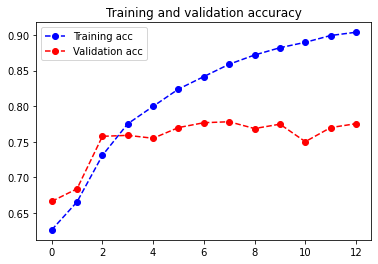

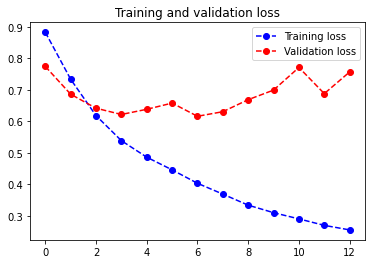

In [56]:
import matplotlib.pyplot as plt

acc = model_output.history['accuracy']
val_acc = model_output.history['val_accuracy']
loss = model_output.history['loss']
val_loss = model_output.history['val_loss']

epochs = range(len(acc))

# Displays a plot of the training accuracy and validation accuracy over each epoch
plt.plot(epochs, acc, 'bo--', label='Training acc')
plt.plot(epochs, val_acc, 'ro--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Displays a plot of the training loss and validation loss over each epoch
plt.plot(epochs, loss, 'bo--', label='Training loss')
plt.plot(epochs, val_loss, 'ro--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()